# Summary
This demonstrates reconstruction of a Fresnel CDI dataset and compares the result to ePIE reconstruction. 

The probe structure allows reconstruction in CDI mode, i.e. without real-space overlap constraints. 

Scanning CDI reconstruction is also possible here, but results in a lower-quality image because of scan position jitter in this dataset.

## Object ePIE reconstruction: 
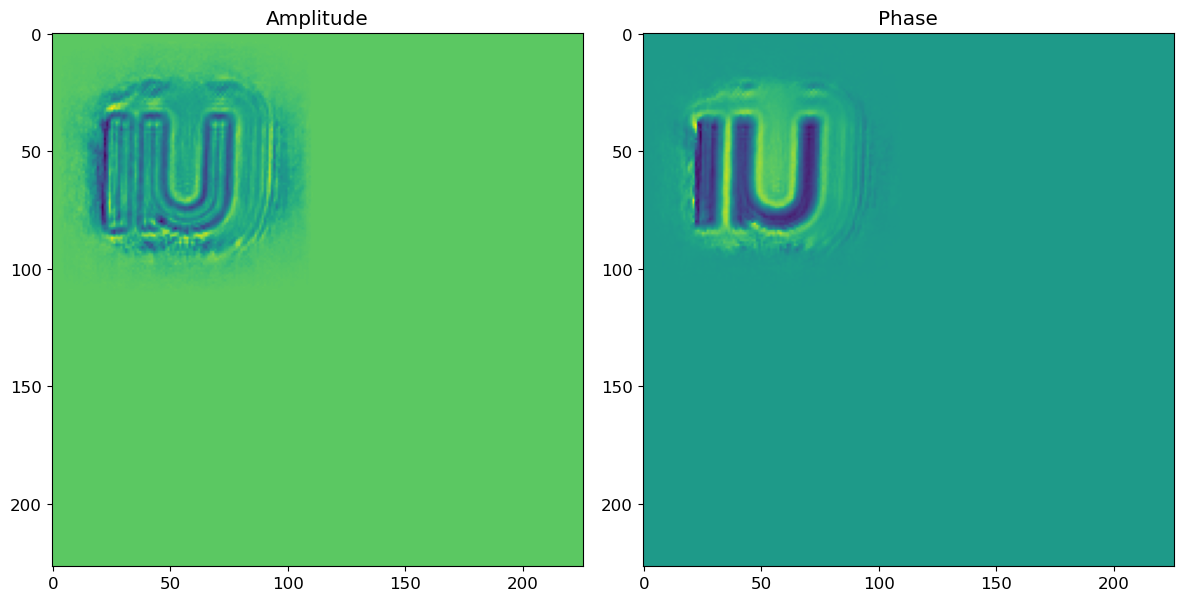

In [1]:
from scipy.ndimage import zoom
import numpy as np

def init():
    from ptycho import params as p
    
    p.cfg['nepochs'] = 50
    p.cfg['output_prefix'] = 'tmp'
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['positions.provided'] = True
    p.cfg['probe.big'] = True
    p.cfg['probe.mask'] = False

    p.cfg['data_source'] = 'generic'
    p.cfg['gridsize'] = 1
    p.cfg['probe_scale'] = 5
    p.cfg['train_data_file_path'] = 'train_data.npz'
    p.cfg['test_data_file_path'] = 'test_data.npz'


# IMPORTANT: must call init() BEFORE the dataset definition
init()

In [2]:
from ptycho.autotest import debug

2 items had no tests:
    __main__
    __main__.init
0 tests in 2 items.
0 passed and 0 failed.
Test passed.


In [3]:
!ln -s ../tests/test_generic_loader.py
import test_generic_loader;
train_raw, test_raw = test_generic_loader.test_generic_loader(False);

ln: failed to create symbolic link './test_generic_loader.py': File exists


2024-06-16 16:59:49.036613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 16:59:49.036644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 16:59:49.037506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-16 16:59:49.042111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 16:59:49.584910: W tensorflow/compiler/tf2

diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
raw diffraction shape (64, 64, 1087)
diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
Train data written to train_data.npz
Test data written to test_data.npz
diff3d shape: (512, 64, 64)
probeGuess 

In [4]:
from ptycho import probe
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

In [5]:
np.save('xprobe0.npz', probeGuess)

In [5]:
probeGuess.shape, probeGuess.dtype

((64, 64), dtype('complex128'))

In [5]:
from ptycho import xpp

In [6]:
ptycho_data.xcoords

array([38.16918273, 38.87603481, 39.16980254, ..., 40.50099972,
       36.57665221, 34.41161596])

In [7]:
tf.random.set_seed(45)
np.random.seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
ptycho_dataset.test_data.X.shape, ptycho_dataset.train_data.X.shape

diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (512, 64, 64, 1)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1087, 64, 64, 1)
INFO: None
<PtychoDataContainer X=(512, 64, 64, 1) Y_I=(512, 64, 64, 1) Y_phi=(512, 64, 64, 1) norm_Y_I=() coords_nominal=(512, 1, 2, 1) coords_true=(512, 1, 2, 1) nn_indices=(512, 1) mean=255.500 global_offsets=(512, 1, 2, 1) mean=63.009 local_offsets=(512, 1, 2, 1) mean=0.000 probe=(64, 64, 1)>
INFO: None
<PtychoDataContainer X=(1087, 64, 64, 1) Y_I=(1087, 64, 64, 1) Y_phi=(1087, 64, 64, 1) norm_Y_I=() coords_nominal=(1087, 1

2024-06-16 17:00:05.554105: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-16 17:00:05.554121: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-06-16 17:00:05.554143: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-06-16 17:00:05.576611: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:163] cuptiEnableCallback: error 1: CUPTI_ERROR_INVALID_PARAMETER
2024-06-16 17:00:05.576625: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-06-16 17:00:05.576630: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-06-16 17:00:05.576637: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
202

Epoch 1/50
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2024-06-16 17:00:08.178978: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-16 17:00:08.179536: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x62c10cdebdd0
2024-06-16 17:00:09.613222: I external/local_xla/xla/service/service.cc:168] XLA service 0x77c4c8efcb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-16 17:00:09.613248: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-16 17:00:09.617630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718571609.740996 2804681 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 10s 83ms/step - loss: 341151712.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 142.4253 - distribution_lambda_loss: 341151712.0000 - val_loss: 190249440.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 109.3996 - val_distribution_lambda_loss: 190249440.0000 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 185771760.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 108.9614 - distribution_lambda_loss: 185771760.0000 - val_loss: 130607856.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 91.3346 - val_distribution_lambda_loss: 130607856.0000 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 137161376.0000 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 93.9806 - distribution_lambda_loss: 137161376.0000 - val_loss: 104405760.0000 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 82.9512 - val

(TensorShape([1087, 64, 64, 1]), TensorShape([512, 64, 64, 1]))

# Dataset description

In [9]:
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data

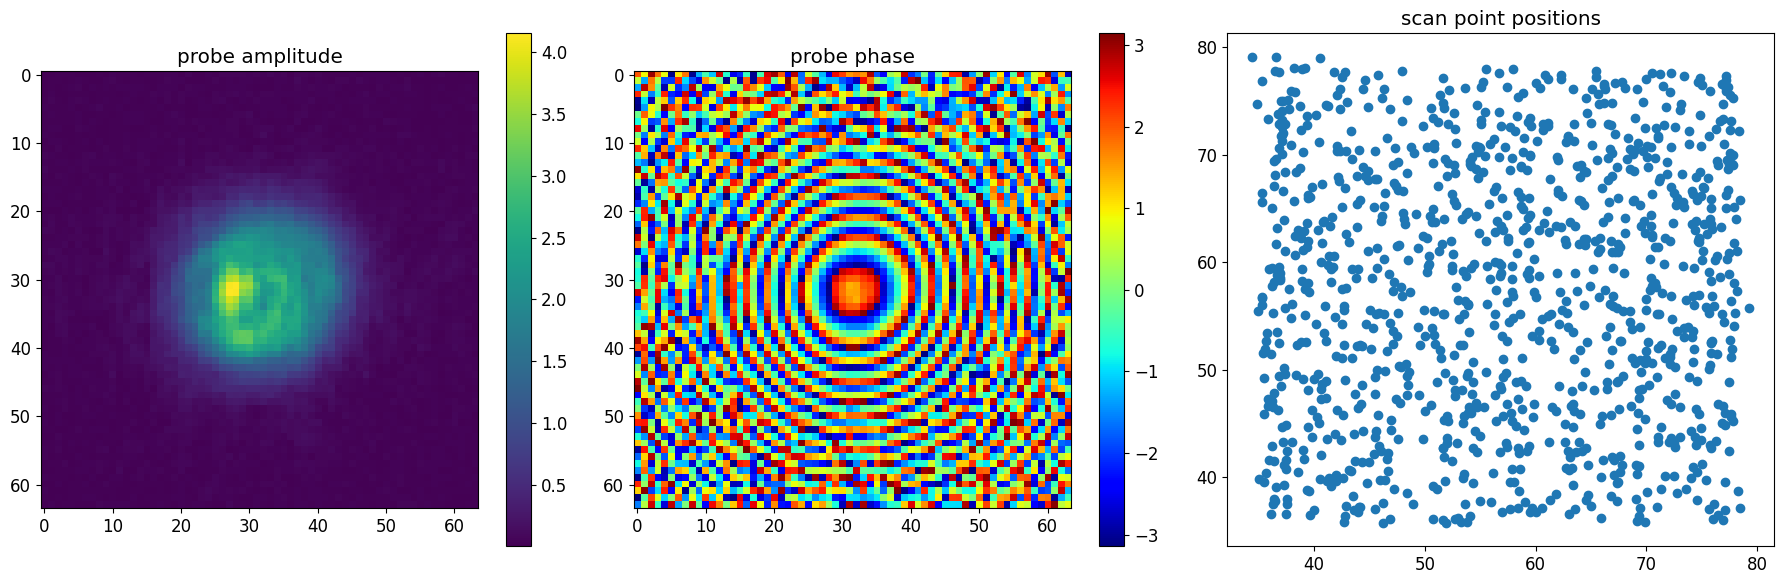

In [10]:
# Note the randomized scan point positions
probeshow(probeGuess, ptycho_dataset.test_data)

## Reconstruct the full test object image and compare to the ePIE reconstruction:

<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>CALL
type=<class 'tensorflow.python.framework.ops.SymbolicTensor'>, shape=(None, 64, 64, 1), dtype=<dtype: 'float32'>
type=<class 'dict'>
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>ERROR Input data is not picklable
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>CALL
type=<class 'tensorflow.python.framework.ops.SymbolicTensor'>, shape=(None, 64, 64, 1), dtype=<dtype: 'float32'>
type=<class 'dict'>
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>ERROR Input data is not picklable
34/34 [==============================] - 0s 5ms/step
<ptycho.loader.reassemble_position.reassemble_position>CALL
type=<class 'numpy.ndarray'>, shape=(1087, 64, 64, 1), dtype=complex64, type=<class 'numpy.ndarray'>, shape=(1087, 1, 2, 1), dtype=float64
type=<class 'dict'>
<ptycho.loader.shift_and_sum.shift_and_sum>CALL


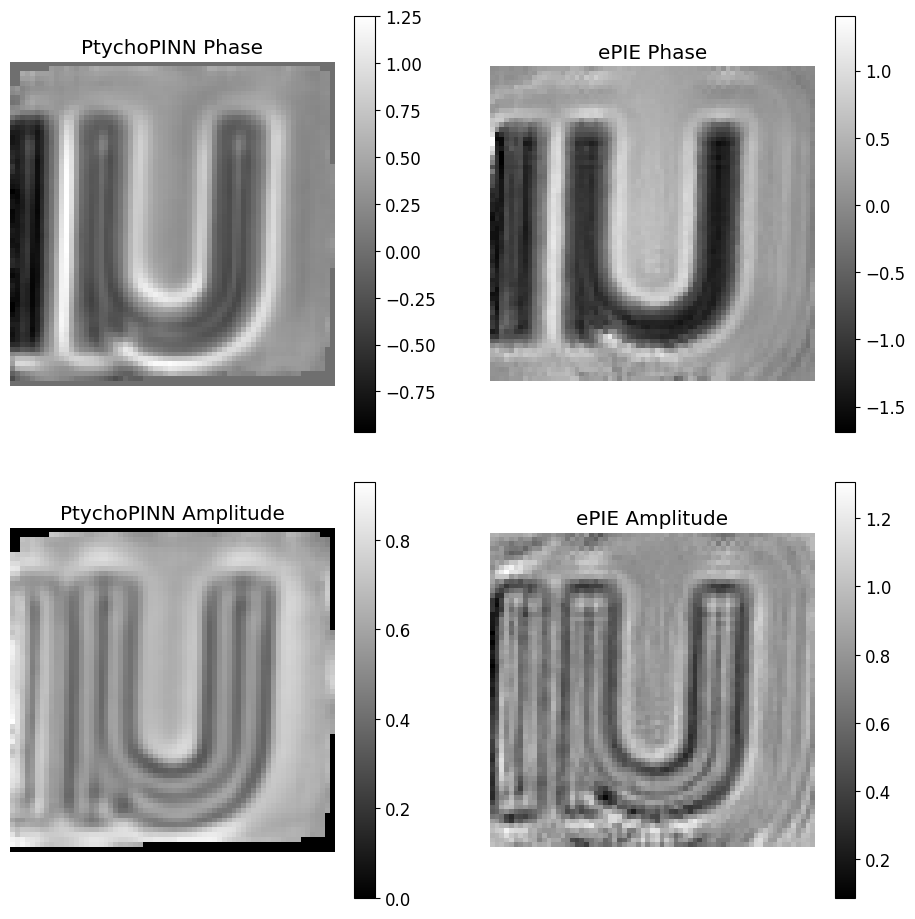

CPU times: user 6.02 s, sys: 967 ms, total: 6.98 s
Wall time: 6.6 s


In [11]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

102/102 [==============================] - 1s 6ms/step
PADDING SIZE: 22
PADDING SIZE: 22


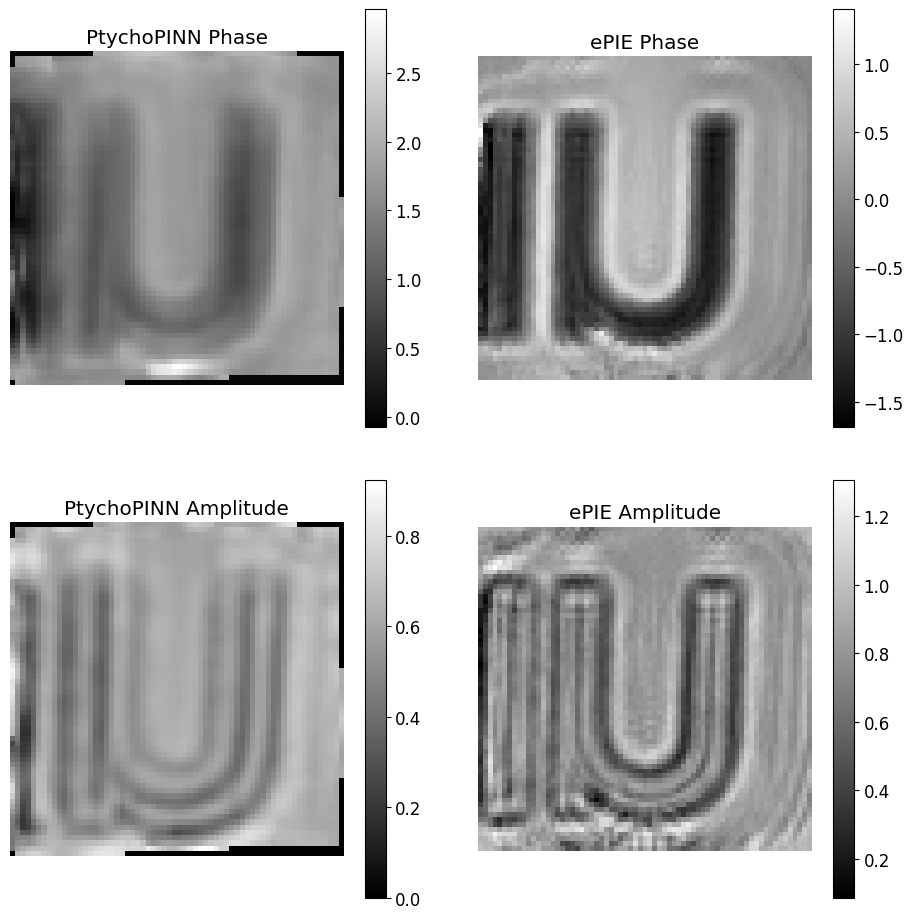

CPU times: user 1.28 s, sys: 588 ms, total: 1.87 s
Wall time: 1.68 s


In [9]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

Reconstruction for a single solution region:

phase min: -3.141592 phase max: 3.141569


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/evaluation.py:80: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


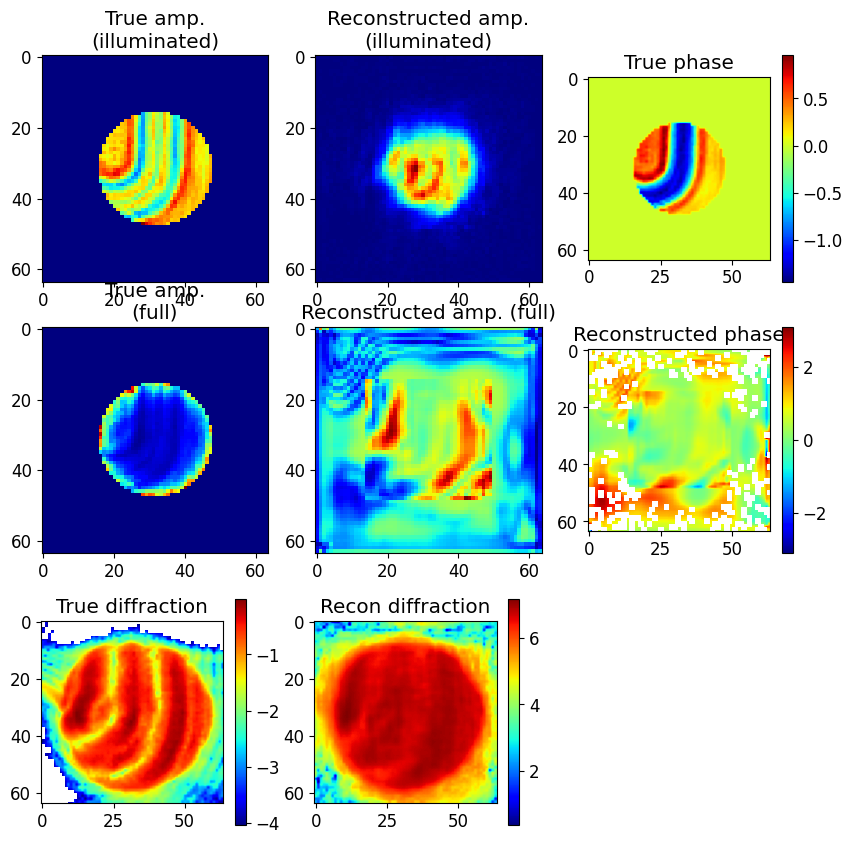

In [11]:
i = 200
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0, 0]), 0,
                    crop = False);

In [ ]:
# TODO: is the loss different here from on the main branch?

In [15]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
# moved to logging.py

# import os
# import json
# from typing import List, Tuple, Union
# from ptycho.logging import LoggedDataNotFoundError, load_logged_data

# def get_type_and_dim(serialized_data: str) -> str:
#     if serialized_data.startswith("NumPy array"):
#         shape_start = serialized_data.find("shape") + len("shape")
#         shape_end = serialized_data.find("and data type")
#         shape = eval(serialized_data[shape_start:shape_end].strip())
#         dtype = serialized_data[shape_end + len("and data type"):].strip()
#         return f"NumPy array, shape: {shape}, dtype: {dtype}"
#     elif serialized_data.startswith("TensorFlow tensor"):
#         shape_start = serialized_data.find("shape") + len("shape")
#         shape_end = serialized_data.find("and data type")
#         shape = eval(serialized_data[shape_start:shape_end].strip())
#         dtype = serialized_data[shape_end + len("and data type"):].strip()
#         return f"TensorFlow tensor, shape: {shape}, dtype: {dtype}"
#     else:
#         return serialized_data.split(" ")[0]

# def process_log_file(module_path: str, function_name: str) -> None:
#     if function_name.startswith("__init__"):
#         return

#     invocation_index = 0
#     try:
#         inputs, outputs = load_logged_data(module_path, function_name, invocation_index)
#     except LoggedDataNotFoundError:
#         return

#     input_types_dims = []
#     for input_data in inputs["args"]:
#         input_types_dims.append(get_type_and_dim(input_data))
#     for input_name, input_data in inputs["kwargs"].items():
#         input_types_dims.append(f"{input_name}: {get_type_and_dim(input_data)}")

#     output_type_dim = get_type_and_dim(outputs)

#     print(f"Module: {module_path}, Function: {function_name}")
#     print("Input types and dimensionalities:")
#     for input_type_dim in input_types_dims:
#         print(f"  - {input_type_dim}")
#     print(f"Output type and dimensionality: {output_type_dim}")
#     print()

# def extract_logged_data(log_directory: str) -> None:
#     for module_name in os.listdir(log_directory):
#         module_directory = os.path.join(log_directory, module_name)
#         for log_file in os.listdir(module_directory):
#             function_name = log_file.split("_")[0]
#             process_log_file(module_name, function_name)

# def main() -> None:
#     log_directory = "logs/"
#     extract_logged_data(log_directory)

# if __name__ == "__main__":
#     main()

Module: ptycho.loader, Function: get
Input types and dimensionalities:
  - TensorFlow tensor, shape: (227, 226), dtype: <dtype: 'float64'>
  - NumPy array, shape: (512, 1, 2, 1), dtype: float64
  - TensorFlow tensor, shape: (512, 1, 2, 1), dtype: <dtype: 'float64'>
Output type and dimensionality: TensorFlow tensor, shape: (512, 64, 64, 1), dtype: <dtype: 'float64'>

Module: ptycho.loader, Function: 
Input types and dimensionalities:
  - <class
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512, 64, 64), dtype: float64
  - NumPy array, shape: (64, 64), dtype: complex128
  - NumPy array, shape: (512,), dtype: int64
  - objectGuess: NumPy array, shape: (227, 226), dtype: complex128
Output type and dimensionality: <class

Module: ptycho.loader, Function: get
Input types and dimensionalities:
  - TensorFlow tensor, shape: (227,

In [ ]:
pwd